In [2]:
#### 1.Laoding_data.R 
# 1)Read COAD expression data
TCGA_COAD_RNAseqV2_normalized_log2_dataset <- readRDS("/data8t_4/JH/MyJobs/Read_dataset/TCGA_Hub/TCGA_Colon_Cancer_COAD/TCGA_COAD_RNAseqV2_normalized_log2_dataset.rds")
COAD.HiSeqV2.log2 <- TCGA_COAD_RNAseqV2_normalized_log2_dataset$COAD.HiSeqV2.log2
COAD.pheno <- TCGA_COAD_RNAseqV2_normalized_log2_dataset$COAD.pheno
#TCGA_COAD_RNAseqV2_normalized_log2_dataset$COAD.HiSeqV2.metadata
# 2)Read cluster resaults
Cluster.20200201.V7.Tumor <- readRDS("/data8t_4/JH/MyJobs/NormalCancer_TCGA_V2/Cluster.20200201.V7.Tumor.rds")
cutree.res <- Cluster.20200201.V7.Tumor$cutree.res
dynamicColors <- Cluster.20200201.V7.Tumor$dynamicColors
Cluster.df <- cbind(cutree.res,dynamicColors) 
Cluster.df <- as.data.frame(Cluster.df)
Cluster.df$rownames <- rownames(Cluster.df)
hclust.Res <- Cluster.20200201.V7.Tumor$hclust.Res

In [3]:
## 1)Construct COAD Expression set object
library(Biobase)
all(rownames(Cluster.df)==colnames(COAD.HiSeqV2.log2))
## Subset the expression data to Cluster.df
expr.sub <- as.matrix(COAD.HiSeqV2.log2[,colnames(COAD.HiSeqV2.log2) %in% rownames(Cluster.df)])
Cluster.df.sub <- Cluster.df[colnames(expr.sub),1:2]
Cluster.df.sub <- new("AnnotatedDataFrame",
                      data=Cluster.df.sub)
all(rownames(Cluster.df.sub)==colnames(expr.sub))
COAD.ExpressionSet <- ExpressionSet(assayData=expr.sub,phenoData=Cluster.df.sub)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory mat

[1] FALSE

[1] TRUE

In [7]:
## 2)Several Groups experiment design
#COAD.ExpressionSet@phenoData@data
f.expr <- factor(COAD.ExpressionSet@phenoData@data$dynamicColors, levels=c("blue","brown","turquoise","yellow"))
design.expr <- model.matrix(~0+f.expr)
colnames(design.expr) <- c("blue","brown","turquoise","yellow")


Coefficients not estimable: yellow 


Warning message:
“Partial NA coefficients for 15797 probe(s)”

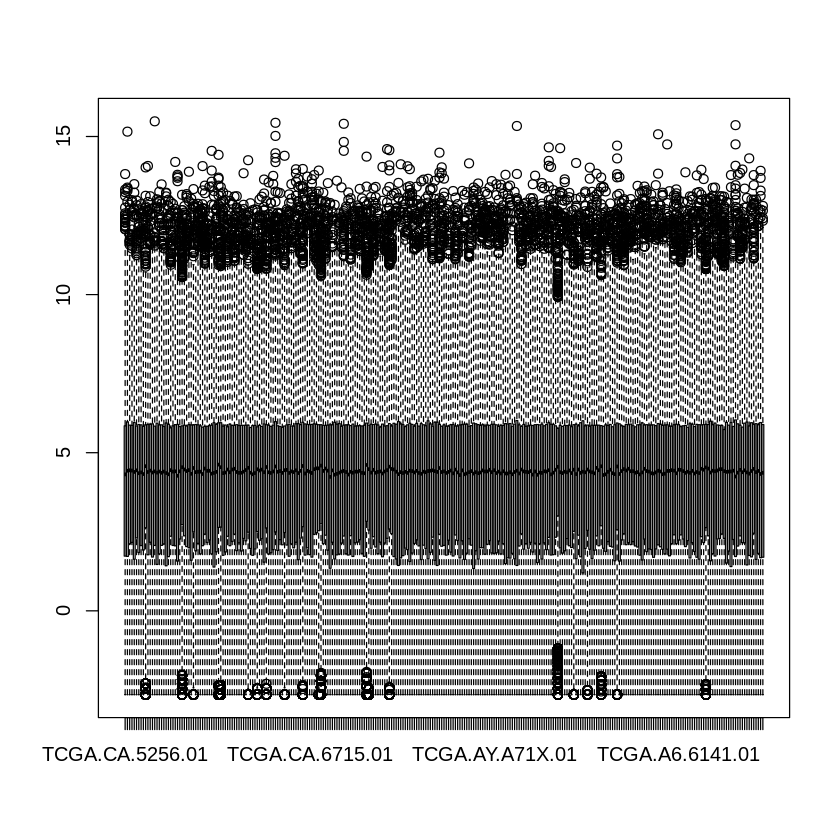

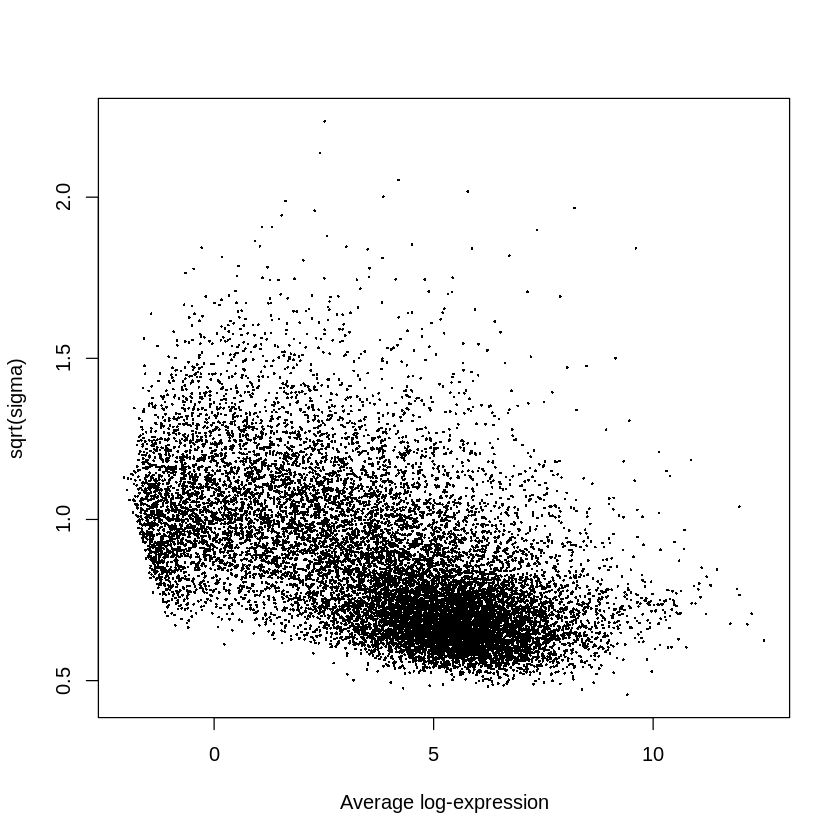

In [10]:
##### 4.1_DEgenes_limma_logCPM_methods.R
### 
x <- 2^exprs(COAD.ExpressionSet) - 1
# DGEList object using the edgeR package
library(edgeR)
dge <- DGEList(counts=x)
## filter
library(edgeR)
keep <- filterByExpr(dge, design.expr)
dge <- dge[keep,,keep.lib.sizes=FALSE]

#normalization to RNA-seq read counts, and the TMM normalization
dge <- calcNormFactors(dge)
#dge$samples$norm.factors

# Differential expression: limma-trend
logCPM <- cpm(dge, log=TRUE, prior.count=3)
#summary(logCPM)
boxplot(logCPM)
#plotMDS(logCPM)
#
fit.lcpm <- lmFit(logCPM, design.expr)
#plotSA(fit.lcpm)
contrast.matrix.expr <- makeContrasts(blue-(brown+turquoise), 
                                      brown-(blue+turquoise),
                                      turquoise-(brown+blue),
                                      levels=design.expr)
fit.lcpm.2 <- contrasts.fit(fit.lcpm, contrast.matrix.expr)
fit.lcpm.2 <- eBayes(fit.lcpm.2)

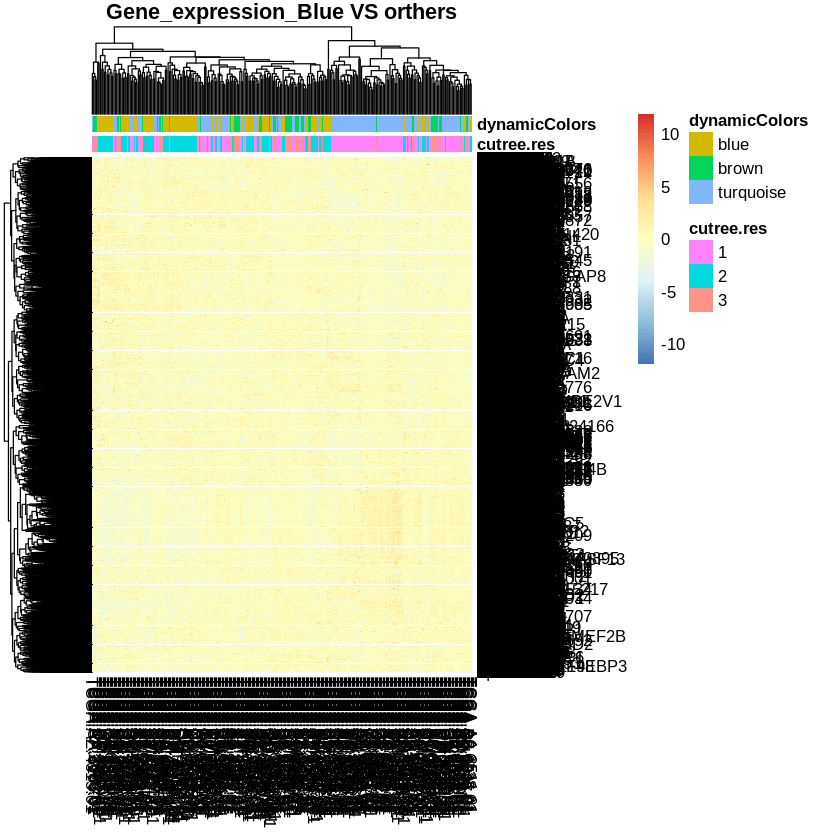

In [11]:
pheatmap::pheatmap(logCPM,annotation_col = pData(COAD.ExpressionSet),
                   main = "Gene_expression_Blue VS orthers",scale="row")
